#Fashion MNIST classification with CNN

Dataset load

torchvision과 transforms를 이용한 dataset 구축

torchvision.datasets.FashionMNIST()를 이용하여 array형태의 학습데이터셋을 반환하는 torch.utils.data.Dataset클래스 load  
torchvision.transforms를 이용하여 해당 데이터를 Tensor로 변환하고 Normalize하여 값을 스케일링 한다.

다음 doc참조:  
FashionMNIST:https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html  
transforms: https://pytorch.org/vision/stable/transforms.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#load할 dataset에 사전작업될 이미지 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])


#torchvision을 통한 dataset load
trainDataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
testDataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

#batch processing을 위한 dataloader 구성
batch_size = 20
trainDataloader = DataLoader(trainDataset, batch_size, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size, shuffle=False)

for i in trainDataloader:
  print(i[0].shape)
  print(i[1].shape)
  break

print(len(trainDataset))
print(len(testDataset))

100%|██████████| 26421880/26421880 [00:02<00:00, 11670399.00it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211713.26it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3924918.11it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22680963.23it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

torch.Size([20, 1, 28, 28])
torch.Size([20])
60000
10000


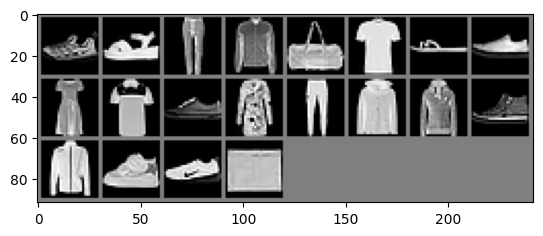

tensor(7) tensor(5) tensor(1) tensor(4) tensor(8) tensor(0) tensor(5) tensor(7) tensor(3) tensor(0) tensor(7) tensor(4) tensor(1) tensor(4) tensor(4) tensor(7) tensor(4) tensor(7) tensor(7) tensor(8)


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainDataloader)
# images, labels = dataiter.next() -> AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % labels[j] for j in range(batch_size)))

Model 선언
nn.Module를 통해 모델의 구조결정

CNN 기반의 모델을 선언한다.  
모델의 구조는  
**2D CNN** with kernelsize=5,5 out_channel = 6, activation=ReLU    
**maxpooling** kernelsize=2,2 stride=2    
**2D CNN** with kernelsize=5,5 out_channel = 16, stride = 2, activation=ReLU  
**1st layer MLP** out_feature = 120, activation=ReLU  
**output layer MLP** out_feature = num_class  


각 오브젝트의 입력과 선언은 다음 doc 참조:  
Conv2d: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html  
MaxPool2d: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html  
Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [3]:
import torch.nn as nn

class myModel(nn.Module):
    def __init__(self):
      super(myModel, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
      self.maxpool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=2)
      self.linear1 = nn.Linear(16*4*4, 120)
      self.linear2 = nn.Linear(120, 10)
      self.relu = nn.ReLU()

    def forward(self, x):
      # N * 1 * 28 * 28
      x = self.conv1(x)
      # N * 6 * 24 * 24
      x = self.relu(x)
      x = self.maxpool(x)
      # N * 6 * 12 * 12
      x = self.conv2(x)
      # N * 16 * (12-5)/2 +1 * (12-5)/2 +1 = N * 16 * 4 * 4
      x = self.relu(x)
      x = x.reshape(-1, 16 * 4 * 4)
      x = self.linear1(x)
      x = self.relu(x)
      x = self.linear2(x)
      return x

model = myModel().cuda()

for i in trainDataloader:
    data = i[0].cuda()
    target = i[1].cuda()

    print(model(data).shape)
    break

torch.Size([20, 10])


작성한 dataset과 model을 이용하여 딥러닝 프로세스 구현  

pytorch 딥러닝 프로세스
1. dataset, model선언
2. dataset과 model을 통한 결과 예측
3. 예측된 결과를 통해 **loss**연산 및 **loss.backward**
4. **optimizer.step()**를 사용하여 graident update

주요 오브젝트  
torch.nn.CrossEntropyLoss: 문장 분류를 위한 loss 수행  
torch.optim.Adam: Adam optimizer를 통해 gradient update를 수행하는 class

각 오브젝트의 입력과 선언은 다음 doc 참조:  
CrossEntropyLoss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html  
Adam: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [5]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# 학습을 위한 optimizer와 loss function 설정
optimizer = Adam(model.parameters(), lr=0.001)
lf = CrossEntropyLoss()

# 100번의 에폭을 실행
for e in range(100):
  print("\n\nepoch ", e)
  epoch_loss = 0
  train_correct = 0

  # 선언한 모델 오브젝트를 학습가능한 상태로 변경
  model.train()

  # 모든 학습데이터에 대해서 학습
  for i in trainDataloader:
    # 매 배치에 대한 gradient계산 이전에 optimizer에 저장된 이전 batch에 gradient를 삭제(초기화)
    optimizer.zero_grad()

    data = i[0].cuda()
    target = i[1].cuda()

    # 결과 도출 및 정답수 연산
    output = model(data)
    pred_label = torch.argmax(output, dim=-1)
    train_correct += sum(pred_label == target.reshape(-1))

    # loss연산
    loss = lf(output, target)

    # loss backpropagation
    loss.backward()

    #gradient update
    optimizer.step()

    epoch_loss += loss.item()

  print("train loss", epoch_loss/len(trainDataloader))
  print("train acc", train_correct/len(trainDataset))

  # model이 학습되지 않는 상태로 변경
  model.eval()

  test_loss = 0
  test_correct = 0

  # gradient를 계산하지 않도록 하여 cost낭비 방지
  with torch.no_grad():
    # 모든 test dataset에 대해서 결과연산
    for i in testDataloader:
      data = i[0].cuda()
      target = i[1].cuda()

      output = model(data)

      loss = lf(output, target)
      pred_label = torch.argmax(output, dim=-1)
      test_correct += sum(pred_label == target.reshape(-1))
      test_loss += loss.item()

  print("test loss", test_loss/len(testDataloader))
  print("test acc", test_correct/len(testDataset))



epoch  0
train loss 0.06556312549820303
train acc tensor(0.9761, device='cuda:0')
test loss 0.8499926469256752
test acc tensor(0.8894, device='cuda:0')


epoch  1
train loss 0.0579294292951026
train acc tensor(0.9790, device='cuda:0')
test loss 0.8922498294536781
test acc tensor(0.8854, device='cuda:0')


epoch  2
train loss 0.058103832985970445
train acc tensor(0.9788, device='cuda:0')
test loss 0.9423910499926206
test acc tensor(0.8795, device='cuda:0')


epoch  3
train loss 0.05724974024090708
train acc tensor(0.9795, device='cuda:0')
test loss 0.9519075162930494
test acc tensor(0.8828, device='cuda:0')


epoch  4
train loss 0.05543753542977693
train acc tensor(0.9794, device='cuda:0')
test loss 0.9487490630653956
test acc tensor(0.8823, device='cuda:0')


epoch  5
train loss 0.058345812125228005
train acc tensor(0.9796, device='cuda:0')
test loss 0.960830962895845
test acc tensor(0.8834, device='cuda:0')


epoch  6
train loss 0.056089680266485864
train acc tensor(0.9797, device='